In [10]:
import numpy as np
import pandas as pd
import torch
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data, Batch
from torch_geometric.transforms import LocalDegreeProfile
import torch.nn.functional as F
from torch_geometric.datasets import GemsecDeezer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, average_precision_score
import pathlib
import utils
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# finding the current path
base_dir = pathlib.Path().resolve()
node_n2v_df, node_w2v_df, node_target_df, node_indication_df, node_fin_df = utils.load_node_features_datasets()
nodes_df = [node_n2v_df, node_w2v_df, node_target_df, node_indication_df, node_fin_df]
edge_atc_df, edge_fing_df, edge_maxSim_df, edge_n2v_df, edge_target_df, edge_w2v_df = utils.load_edges_df()
edges_df = [edge_atc_df, edge_fing_df, edge_maxSim_df, edge_n2v_df, edge_target_df, edge_w2v_df]
nodes_datasets = ['Node2Vec', 'Word2Vec', 'Target', 'Indication', 'Fingerprint']
edges_datasets = ['ATCSimilarity', 'FingerprintSimilarity', 'MaxSimWithoutside', 'Node2VecSimilarity', 'TargetSimilarity', 'Word2VecSimilarity']
se_df = pd.read_csv(f'{base_dir}/datasets/sideEffectsfillterd.csv', index_col='DCC_ID')
del se_df['Unnamed: 0']

In [11]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hid_channels, out_channels):
        super(GNN, self).__init__()
        torch.manual_seed(0)
        self.conv1 = GCNConv(in_channels=in_channels, out_channels=hid_channels)
        self.conv2 = GCNConv(in_channels=hid_channels, out_channels=hid_channels)
        self.conv3 = GCNConv(in_channels=hid_channels, out_channels=out_channels)
        # self.lin1 = torch.nn.Linear(in_features=hid_channels, out_features=out_channels)
        # self.conv4 = GATConv(in_channels=)

    def forward(self, x, edge_index, index=0):
        if index == 0:
            x = self.conv1(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv2(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv3(x, edge_index)
        # x = self.lin1(x)
        # x = x.sigmoid()
        return x

In [12]:
graph_data_list = []
title_list = []
for i in range(len(nodes_datasets)):
    for j in range(len(edges_datasets)):
        node_title = nodes_datasets[i]
        edge_title = edges_datasets[j]
        if node_title not in edge_title:
            title = f'{node_title} - {edge_title}'
            data = utils.create_graph(edges_df[j], se_df, nodes_df[i], least_score=0.8)
            title_list.append(title)
            graph_data_list.append(data)

In [14]:
score_list = []
for i, data in enumerate(graph_data_list):
    title = title_list[i]
    losses, auc_score_list, aupr_score_list = utils.train_and_test(data, GNN, 101, with_auc=True, with_aupr=True, with_f1=False, plot_training=False, print_logs=False, index=0)
    print(title, 'Loss:', losses[-1], 'AUC:', auc_score_list[-1], 'AUPR:', aupr_score_list[-1])
    score_list.append([title, losses, auc_score_list, aupr_score_list])

Node2Vec - ATCSimilarity Loss: 0.108 AUC: 0.778 AUPR: 0.459
Node2Vec - FingerprintSimilarity Loss: 0.1 AUC: 0.887 AUPR: 0.61
Node2Vec - MaxSimWithoutside Loss: 0.108 AUC: 0.736 AUPR: 0.405
Node2Vec - TargetSimilarity Loss: 0.092 AUC: 0.893 AUPR: 0.612
Node2Vec - Word2VecSimilarity Loss: 0.092 AUC: 0.947 AUPR: 0.763
Word2Vec - ATCSimilarity Loss: 0.098 AUC: 0.807 AUPR: 0.489
Word2Vec - FingerprintSimilarity Loss: 0.099 AUC: 0.879 AUPR: 0.598
Word2Vec - MaxSimWithoutside Loss: 0.1 AUC: 0.778 AUPR: 0.438
Word2Vec - Node2VecSimilarity Loss: 0.098 AUC: 0.801 AUPR: 0.442
Word2Vec - TargetSimilarity Loss: 0.094 AUC: 0.886 AUPR: 0.607
Target - ATCSimilarity Loss: 0.122 AUC: 0.637 AUPR: 0.297
Target - FingerprintSimilarity Loss: 0.135 AUC: 0.7 AUPR: 0.407
Target - MaxSimWithoutside Loss: 0.121 AUC: 0.606 AUPR: 0.27
Target - Node2VecSimilarity Loss: 0.117 AUC: 0.591 AUPR: 0.248
Target - Word2VecSimilarity Loss: 0.146 AUC: 0.832 AUPR: 0.602
Indication - ATCSimilarity Loss: 0.115 AUC: 0.699 AUPR: 

In [15]:
f = open(f'{base_dir}/generated/all.txt', 'w')
f.write(str(score_list))
f.flush()

In [16]:
graph_data_list = []
title_list = []
for i in range(len(nodes_datasets)):
    for j in range(len(edges_datasets)):
        node_title = nodes_datasets[i]
        edge_title = edges_datasets[j]
        if node_title not in edge_title:
            title = f'{node_title} - {edge_title}'
            data = utils.create_graph(edges_df[j], se_df, nodes_df[i], least_score=0.7)
            title_list.append(title)
            graph_data_list.append(data)

In [17]:
score_list = []
for i, data in enumerate(graph_data_list):
    title = title_list[i]
    losses, auc_score_list, aupr_score_list = utils.train_and_test(data, GNN, 101, with_auc=True, with_aupr=True, with_f1=False, plot_training=False, print_logs=False, index=0)
    print(title, 'Loss:', losses[-1], 'AUC:', auc_score_list[-1], 'AUPR:', aupr_score_list[-1])
    score_list.append([title, losses, auc_score_list, aupr_score_list])

Node2Vec - ATCSimilarity Loss: 0.108 AUC: 0.778 AUPR: 0.459
Node2Vec - FingerprintSimilarity Loss: 0.112 AUC: 0.725 AUPR: 0.403
Node2Vec - MaxSimWithoutside Loss: 0.11 AUC: 0.675 AUPR: 0.35
Node2Vec - TargetSimilarity Loss: 0.093 AUC: 0.882 AUPR: 0.601
Node2Vec - Word2VecSimilarity Loss: 0.107 AUC: 0.797 AUPR: 0.502
Word2Vec - ATCSimilarity Loss: 0.098 AUC: 0.807 AUPR: 0.489
Word2Vec - FingerprintSimilarity Loss: 0.109 AUC: 0.734 AUPR: 0.41
Word2Vec - MaxSimWithoutside Loss: 0.101 AUC: 0.751 AUPR: 0.405
Word2Vec - Node2VecSimilarity Loss: 0.096 AUC: 0.741 AUPR: 0.395
Word2Vec - TargetSimilarity Loss: 0.094 AUC: 0.871 AUPR: 0.59
Target - ATCSimilarity Loss: 0.122 AUC: 0.637 AUPR: 0.297
Target - FingerprintSimilarity Loss: 0.12 AUC: 0.577 AUPR: 0.249
Target - MaxSimWithoutside Loss: 0.119 AUC: 0.559 AUPR: 0.238
Target - Node2VecSimilarity Loss: 0.109 AUC: 0.572 AUPR: 0.232
Target - Word2VecSimilarity Loss: 0.121 AUC: 0.66 AUPR: 0.363
Indication - ATCSimilarity Loss: 0.115 AUC: 0.699 AUPR

In [57]:
for row in score_list:
    title = row[0]
    loss = row[1]
    auc = row[2]
    aupr = row[3]
    print(title, 'Loss:', loss[-1], 'AUC:', auc[-1], 'AUPR:', aupr[-1])

ATCSimilarity Loss: 0.109 AUC: 0.776 AUPR: 0.46
fingerSimilarity Loss: 0.115 AUC: 0.707 AUPR: 0.385
maxSimWithoutside Loss: 0.111 AUC: 0.668 AUPR: 0.345
TargetSimilarity Loss: 0.092 AUC: 0.893 AUPR: 0.614
word2vecSimilarity Loss: 0.108 AUC: 0.8 AUPR: 0.511


In [60]:
f = open(f'{base_dir}/generated/w2v.txt', 'w')
f.write(str(score_list))
f.flush()

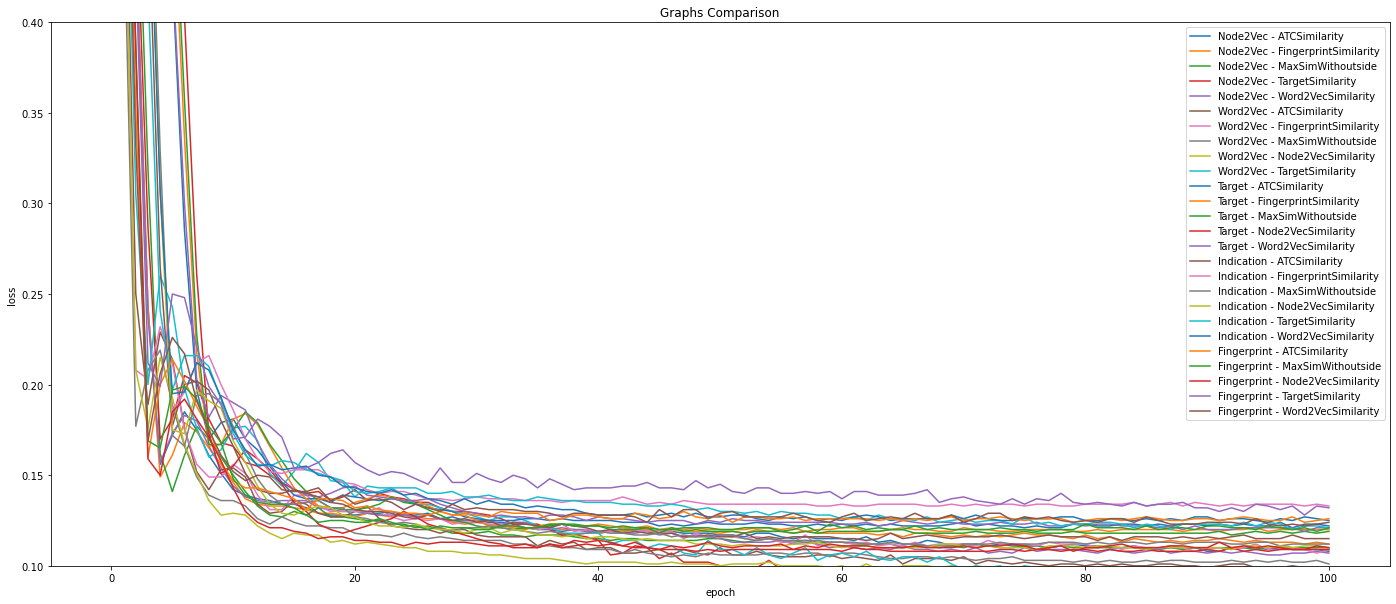

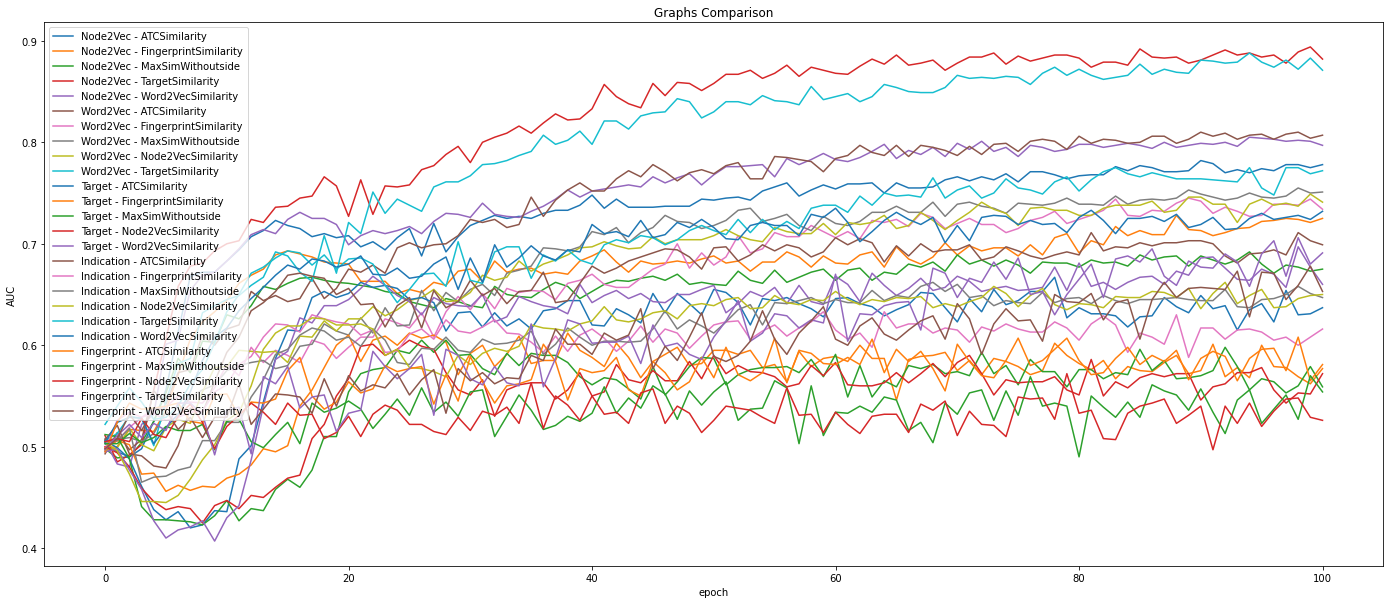

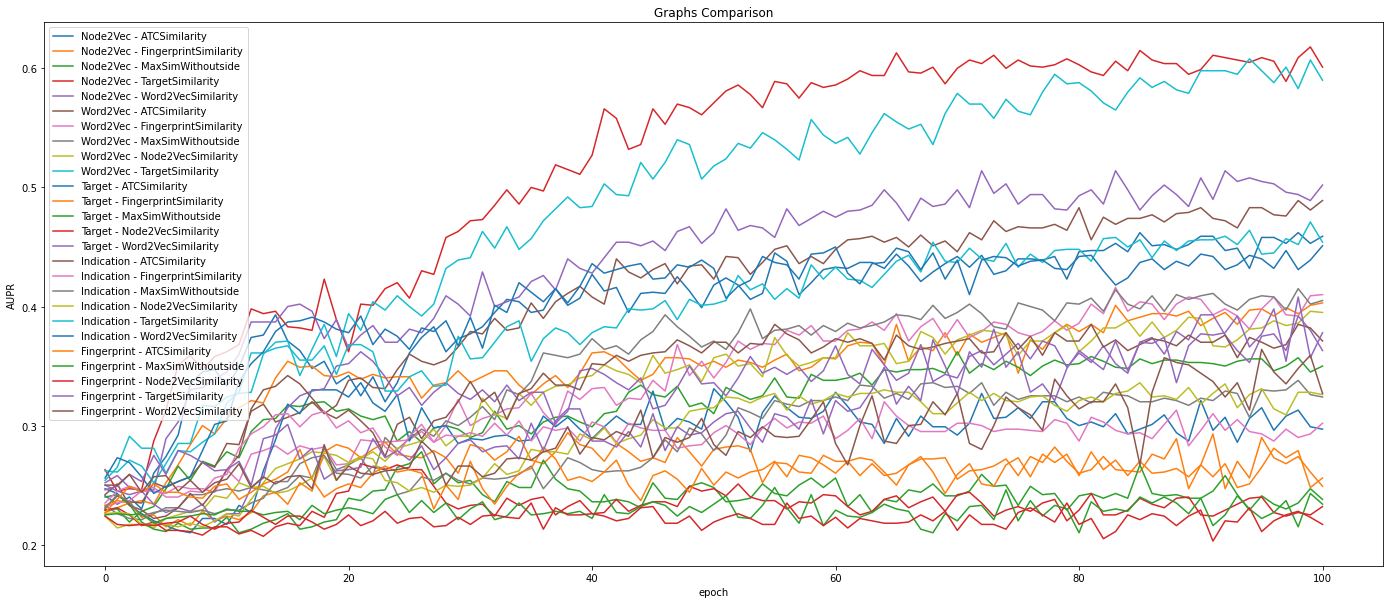

In [19]:
plt.figure(figsize=(24, 10))
for row in score_list:
    title = row[0]
    loss_list = row[1]
    auc_list = row[2]
    aupr_list = row[3]
    plt.plot(loss_list, label=title)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Graphs Comparison')
plt.ylim(0.1, 0.4)
plt.legend()
plt.show()
##############################################
plt.figure(figsize=(24, 10))
for row in score_list:
    title = row[0]
    loss_list = row[1]
    auc_list = row[2]
    aupr_list = row[3]
    plt.plot(auc_list, label=title)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('Graphs Comparison')
# plt.ylim(0.1, 0.4)
plt.legend()
plt.show()
##############################################
plt.figure(figsize=(24, 10))
for row in score_list:
    title = row[0]
    loss_list = row[1]
    auc_list = row[2]
    aupr_list = row[3]
    plt.plot(aupr_list, label=title)
plt.xlabel('epoch')
plt.ylabel('AUPR')
plt.title('Graphs Comparison')
# plt.ylim(0.1, 0.4)
plt.legend()
plt.show()